<font size=6> <b> Time Series Notebook </b> </font>
<div class="alert alert-block alert-success">
  Time-Series 데이터를 다루기 위한 기본적인 지식들을 훑어보자!<br>
</div>
</div>

<p style="text-align:right;"> sumyeon@gmail.com </p>


<hr>

> supress annoying warnings

In [186]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

> import libraries
- let's import required librariees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas_datareader.data as pdrdata
from tqdm.notebook import tqdm

%matplotlib inline

> 한글 폰트 로딩 (참조:  http://corazzon.github.io/matplotlib_font_setting ) <br>
- 한글 폰트가 없어 한글 표시가 안되는 문제 해결을 위해, True-Type 한글 폰트를 로딩하는 법

In [2]:
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\\WINDOWS\\Fonts\\HYWULM.TTF').get_name()   # linux인 경우도 동일하게 사용할 한글 폰트 위치를 설정해주면 됨. ex) '/Library/Fonts/NanumBarunGothic.ttf'
plt.rc('font', family=font_name)

<hr>

> Sample Data
- 삼성 전자의 '20 1/1 ~ '22 5/28일까지의 'Close' 값을 TS 샘플로 사용


In [3]:
df= pdrdata.DataReader('005930', 'naver', '2020-01-01','2022-05-27')
for col in df:
    df[col] = df[col].astype(int)
df

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,55500,56000,55000,55200,12993228
2020-01-03,56000,56600,54900,55500,15422255
2020-01-06,54900,55600,54600,55500,10278951
2020-01-07,55700,56400,55600,55800,10009778
2020-01-08,56200,57400,55900,56800,23501171
...,...,...,...,...,...
2022-05-23,68800,68800,67600,67900,13684088
2022-05-24,67500,67700,66500,66500,15482576
2022-05-25,66700,67100,65900,66400,15150490


<hr>

# Time Series 데이터 분석 개요

## Time Series 분석에 대해 좋았던 글 리스트  <br>

SARIMA timeseries prediction
The best explanation and comparison on many kinds of timeseries prediction <br>
https://towardsdatascience.com/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-series-data-509a5d87f20a

step by step guide <br>
https://towardsdatascience.com/end-to-end-time-series-analysis-and-modelling-8c34f09a3014

Identifying the optimal parameter for AR/MA terms <br>
https://people.duke.edu/~rnau/411arim3.htm

Step-by-step guide to use ARIMA model <br>
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

detailed explanation <br>
https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578

best explanation <br>
https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

Sesonality working in Triple Explonetial Smoothing (Charles Holt and his student Peter Winters) <br>
https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm

LSTM article <br>
https://medium.com/swlh/a-quick-example-of-time-series-forecasting-using-long-short-term-memory-lstm-networks-ddc10dc1467d

## Time Series 데이터 분석 개요 <br>

-  Time Series (시계열) 분석의 목적이 대부분 (미래 트렌드를) 예측함으로써 당면 문제를 해결하는 경우임 <br>
예를 들어, 주가 예측, 판매 예측 등의 경우 정확한 예측이 필요한 문제이며, Outlier detection도 결국 <br>
특정 지점에서의 예측값과 실제 값의 차이가 예외적으로 큰 경우를 찾는 문제임 <br> 

=> 결국, (미래) 데이터를 예측하는 문제가 시계열 분석의 핵심 이슈임

- (미래 트렌드를) 예측하기 위해서는, 예측에 도움이 될 만한 hint가 있어야 하는데 대부분의 경우 <br>
가장 중요한 hint는 과거 데이터님. 즉, 대상 데이터의 과거 이력을 가지고 특정 상황의 값을 예측하게됨 <br>


- 이런 방향으로, 시계열 분석의 중요한 두 가지 축은 아래와 같음
> Univariate Time Series Forecasting vs. Multivariate Time Series Forecasting  <= 다루지 않음<br>
> 과거 데이터를 이용한 미래 예측 방법은? <= 이하 설명

- 과거 데이터를 이용하는 주요 아이디어는 아래와 같다

1) Moving Average : 과거 데이터들의 평균 값으로 미래 값을 결정
  > moving average, weighted moving average, exponential (weighted) moving average 등 다양한 방식 존재
  
2) Auto Regression : 과거 데이터들을 인자로 하는 (linear regression) 함수로 미래 값을 결정
  > 1차, 2차, .... , n차 모델등 다양한 방식의 모델이 존재


## Raw Data

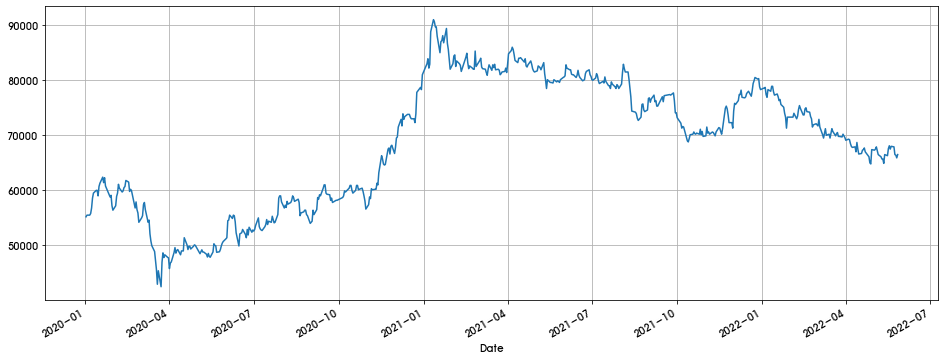

In [4]:
ax = df['Close'].plot(figsize=(16,6))
ax.grid(True)
#plt.scatter(stock2df.index, stock2df['Close'], color='Black')

## Moving Average (MA)

### Moving Average (MA - Rolling Window)

In [19]:
def plot_moving_average(series, window, plot_intervals=True, scale=1.96):  # 99% = 2.575, 95% = 1.96
    
    plt.figure(figsize=(16,6))
    plt.title(f"Moving average window size = {window}")
    
    plt.plot(series[window:], 'g', label = 'Actual Values')
    rolling_mean = series.rolling(window=window).mean()
    plt.plot(rolling_mean, 'm', label='moving average trend')
    
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (scale * deviation)
        upper_bound = rolling_mean + (scale * deviation)
        plt.plot(upper_bound, color='lightcoral', linestyle='--', label='Upper bound/ Lower bound')
        plt.plot(lower_bound, color='lightcoral', linestyle='--', label='Upper bound/ Lower bound')
        
    
    plt.legend(loc='best')
    plt.grid(True)

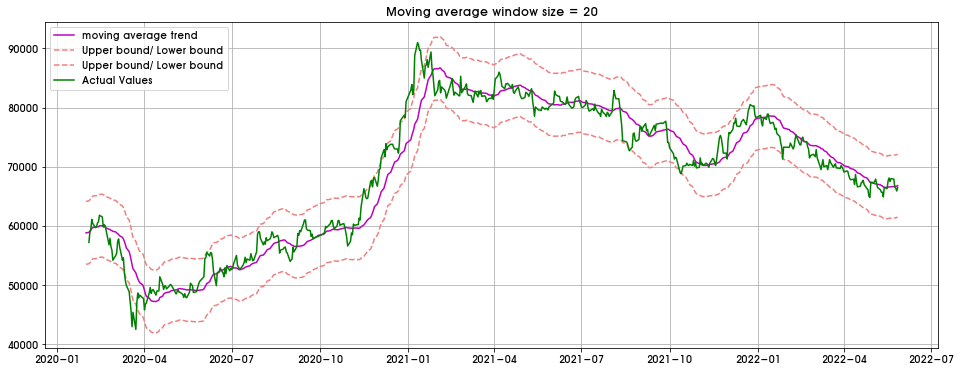

In [35]:
plot_moving_average(df['Close'], 20)

### Exponential Weighted Moving Average (EWMA)

In [143]:
def plot_exponential_weighted_moving_average(series, alphas):
    
    plt.figure(figsize=(16,6))
    plt.plot(series, color="g", label = 'Actual Values')
    
    for alpha in alphas:
        plt.plot( series.ewm(alpha=alpha).mean(), linestyle='--', label=f"Alpha_{alpha}")
    
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Exponential Weighted Moving Average')
    plt.grid(True)

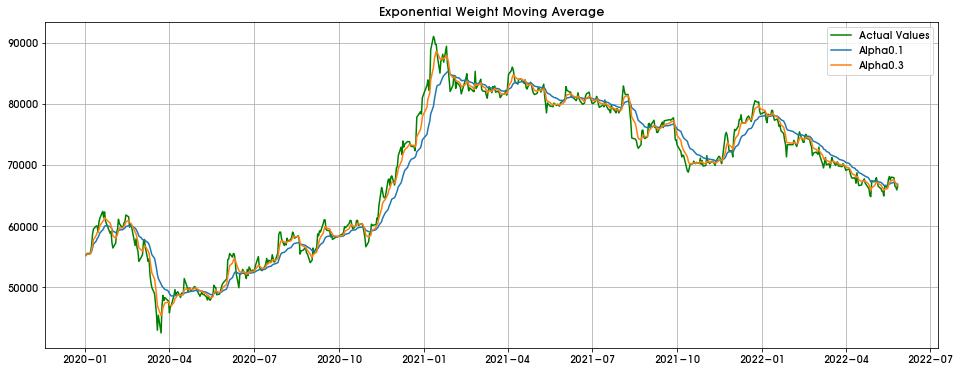

In [144]:
plot_exponential_weight_moving_average(df['Close'], [0.1, 0.3])

## Auto Regression (AR)

In [5]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

### Auto Regression (AR)
> 과거 데이터들의 다향식으로 다음 값을 예측

In [171]:
model = AutoReg(df['Close'].values, lags=30)
model_fit = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [176]:
# fitting에 사용된 초기 lags를 제외한 나머지 구간의 값을 predict
reg_result = model_fit.predict()

In [170]:
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 3.69142851e+02  1.01845973e+00 -1.19725278e-02 -3.63639280e-02
  5.99930788e-02 -6.78350939e-02  3.06665688e-03  6.92200693e-02
  2.57028050e-03  2.05185282e-02 -1.04149233e-01 -5.43019507e-03
  3.24181484e-02 -9.13765765e-05  6.36683480e-02 -8.94656085e-03
 -4.01310474e-02  6.64082126e-02 -1.02411832e-01  6.07252202e-02
 -7.96922722e-04 -3.75873824e-02  1.32672877e-02 -3.83458847e-03
  7.86167873e-02 -1.08657978e-01 -4.23255710e-02  9.97224697e-02
  2.29918531e-02 -5.35415131e-02  7.18064170e-03]


In [209]:
def plot_autoregression_window(series, window_size=365, lags=30):

    plt.figure(figsize=(16,6))
    plt.plot(series, color="g", label = 'Actual Values')
    
    train, test = series[0:window_size], series[window_size:len(series)]
    history = [x for x in train]
    
    predictions = list()

    for t in range(len(test)):
        model = AutoReg(history, lags=lags)
        model_fit = model.fit();
        forecast = model_fit.predict(len(history), len(history))  # start, end points to predict. 

        predictions.append(forecast[0])
        history.pop(0)
        history.append(test[t])

    plt.plot(test.index, predictions, color='m', label=f'lags({lags})')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title(f'AutoRegression - windw({window_size})')
    plt.grid(True)
            
    error = mean_squared_error(test, predictions)
    print(f'prediction lag size = {lags}, MSE : {error:.3f}')

prediction lag size = 30, MSE : 954513.993


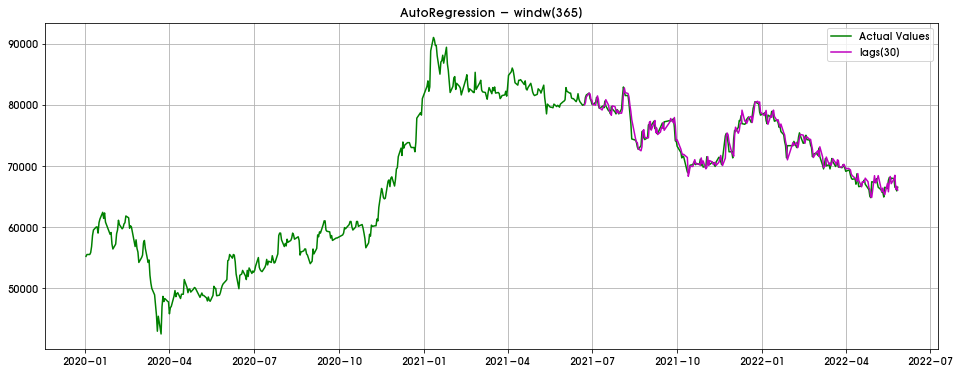

In [210]:
plot_autoregression_window(df['Close'])

# ARIMA (AR + Integrated + MA)

## AutoRegression(AR) + Moving Average(MA)

- Moving Average, Auto Regression을 함께 사용하면 더 효과적이지 않을까? => ARMA

 => 그런데, 가장 정확한 예측을 위한 Auto Regression의 인자 수(lags)는?  PACF 그래프를 참조하여 최적의 P값 결정 <br>
 
 $$ PACF(k)=Corr(e_t, e_{t-k})  \quad where \quad e_t = y_t-(\beta_1y_{t-1} + ... + \beta_{k-1}y_{t-(k-1)}) $$
 
 => Moving average 적용을 위한 window size는? ACF 그래프를 참조하여 최적의 Q값 결정 <br>

$$ ACF(k)=\frac{\sum_{t=1}^{N-k}(y_t-\bar{y})(y_{t+k}-\bar{y})}{\sum_{t=1}^N(y_t-\bar{y})^2} $$


 

## AutoRegression(AR) + Integrated(I) + Moving Average(MA)

- AR 모델은 데이터가 Stationary한 상태일 때 적용 효과가 큼
> Stationary : 데이터가 전체 기간에 걸쳐 mean, variance가 일정한 상태 <br>
- stationary하지 않는 경우 differncing을 통해 stationary 상태로 변경 후 진행

## Stationary

- Stationary data refers to the time series data that mean and variance do not vary across time.

### non-stationary data sample
- mean, variance is increasing across time

- how to transform the data to be stationary
> apply log function to make the variance to be stationary then differentiate values

### Loading data

In [37]:
non_stationary_ts = pd.read_csv("iap.csv")

non_stationary_ts.Month = pd.to_datetime(non_stationary_ts.Month)
non_stationary_ts.set_index('Month', inplace=True)

### Transform the data to be stationary
- diff the values after applying log func.

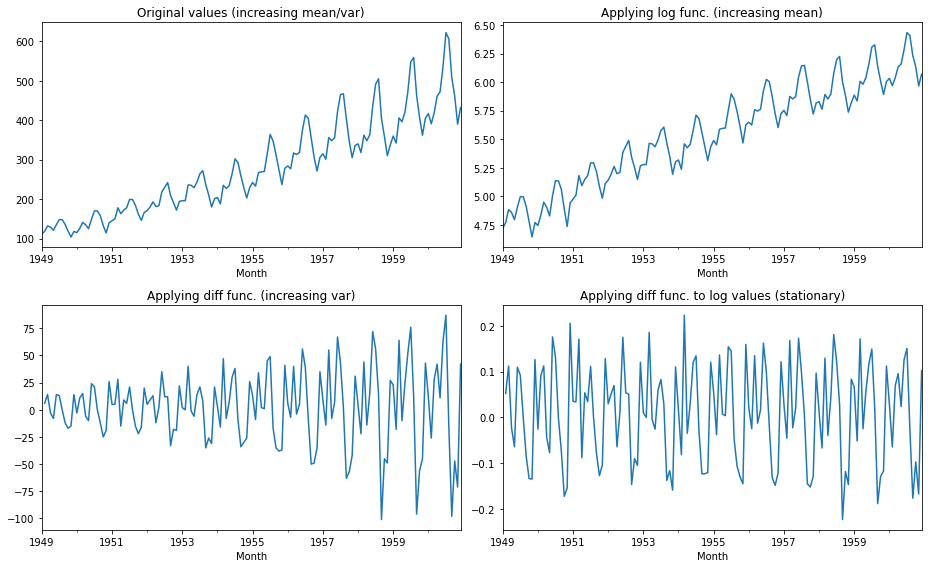

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,8))

non_stationary_ts['Passengers'].plot(ax=axes[0][0])
axes[0][0].set_title("Original values (increasing mean/var)")

non_stationary_ts['log_Passengers'] = np.log(non_stationary_ts['Passengers'])
non_stationary_ts['log_Passengers'].plot(ax=axes[0][1])
axes[0][1].set_title("Applying log func. (increasing mean)")


non_stationary_ts['diff_Passengers'] = non_stationary_ts['Passengers'] - non_stationary_ts['Passengers'].shift(1)
non_stationary_ts['diff_Passengers'].plot(ax=axes[1][0])
axes[1][0].set_title("Applying diff func. (increasing var)")

non_stationary_ts['diff_log_Passengers'] = non_stationary_ts['log_Passengers'] - non_stationary_ts['log_Passengers'].shift(1)
non_stationary_ts['diff_log_Passengers'].plot(ax=axes[1][1])
axes[1][1].set_title("Applying diff func. to log values (stationary)")

fig.tight_layout()

<font size=3> <b> Why not use log-func in ARIMA? </b> </font>
<div class="alert alert-block alert-warning">
  ARIMA 모델에서는 데이터를 staionary 형태로 만들기 위해 differencing만을 사용한다 <br>
  왜 log-func은 사용하지 않는 걸까? 현재까지 정확한 해답은 찾지 못했으며, 대략적으로 <br>
  log-func.을 적용하는 방법의 단점이 장점보다 크거나 자동화가 어려운 것으로 이해하고 있음 <br>
  하지만, fine-tuning을 할때는 직접 수동으로 log를 적용해서 최적화를 하자!!!! 
</div>
</div>


# Time-Series 실제 분석 (ARIMA)

> ARIMA : AR (Auto Regression) - I (Integrated - adopt differencing) - MA (Moving Average)
- Dickey-Fuller Test : Stationary Test
- ACF/PACF graph : finding optimal parameters - p (AR) ,d (Difference for Integration), q (MA)


## 필요한 패키지 import

In [45]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

## Stationary Check & AR/MA Parameter selection


### Augmented Dickey-Fuller Test와 ACF/PACF 그래프를 확인하는 함수

In [46]:
def tsplot(y, lags=None, figsize=(12,7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style=style):    # plt.style.use(style)과 동일한 효과이나 context 내에서만 효력이 발생
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)  # 0,0 위치에 column 길이 2개짜리 그래프 
        acf_ax = plt.subplot2grid(layout, (1,0))            # 1,0 위치에 그래프
        pacf_ax = plt.subplot2grid(layout, (1,1))           # 1,1, 위치에 그래프
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]           # Dickey Fuller 테스트 수행 후 p-value만 확인
        ts_ax.set_title(f"Time Series Analysis Plots \n Dickey-Fuller: p={p_value:.5f}")
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
 

### stattools.adfuller, plot_acf, plot_pacf 함수를 통해, Dickey-Fuller, ACF, PACF 모두를 확인해 보자

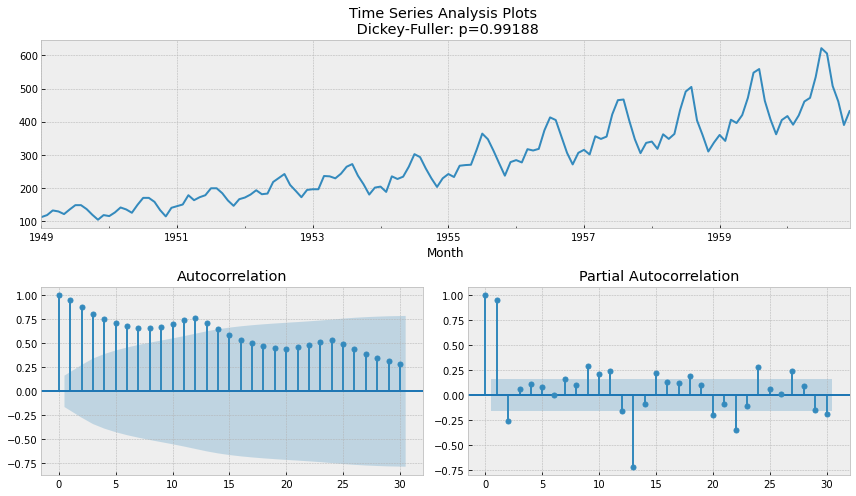

In [47]:
tsplot(non_stationary_ts['Passengers'], lags=30)        

<div class="alert alert-block alert-warning">
  ADF 결과값의 p-value가 0.99로 non-stationary라는 가설을 기각할 수 없음
</div>

### 아직 Stationary하지 않으므로 Differencing을 적용해 보자
> Difference Data :  Data - Data.shift(1)

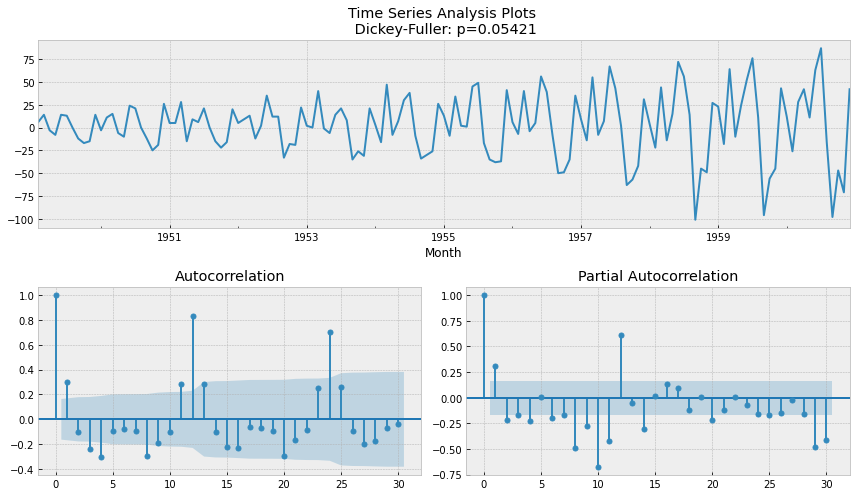

In [51]:
stationary_ts = non_stationary_ts['Passengers'] - non_stationary_ts['Passengers'].shift(1)
tsplot(stationary_ts[1:], lags=30)

<div class="alert alert-block alert-warning">
  ADF 결과값의 p-value가 0.05로 non-stationary라는 가설을 기각할 수 있음. 
</div>

### p (AR) , q (MA) parameter fixing

Autocorrelation그림에서, 1까지가 신뢰구간 밖의 값이므로, q값은 1을 선택 <br>
Partial Autocorrelation 그림에서는 2 또는 4을 p값으로 선택. 

<div class="alert alert-block alert-info">
<b> Tip:</b> order=(p,d,q) <br>
  -  <b> p : </b> the number of lag observations included in this model. <br>
  -  <b> d : </b> the number of times that the raw observations are differenced, also called the degree of differencing <br>
  -  <b> q : </b> the size of moving average window, also called the order of moving average <br> 
</div>

<img width=800 src="https://k.kakaocdn.net/dn/pcuWC/btq5CACTt5C/X3UFPPkwhZpjV59WygsV30/img.png" />

## 모델을 만들고 fiting 시켜 보자

In [65]:
model = ARIMA(non_stationary_ts['Passengers'], order=(2, 1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [66]:
model_fit = model.fit()

### Fiting된 모델 평가

In [67]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                Wed, 01 Jun 2022   AIC                           1378.338
Time:                        23:26:16   BIC                           1390.190
Sample:                    01-01-1949   HQIC                          1383.154
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439      0.073    -11.486      0.0

### Fitting 값과 orginal 값 비교

In [68]:
predict = model_fit.predict(typ='levels')
non_stationary_ts['ARIMA_fit'] = predict

<AxesSubplot:xlabel='Month'>

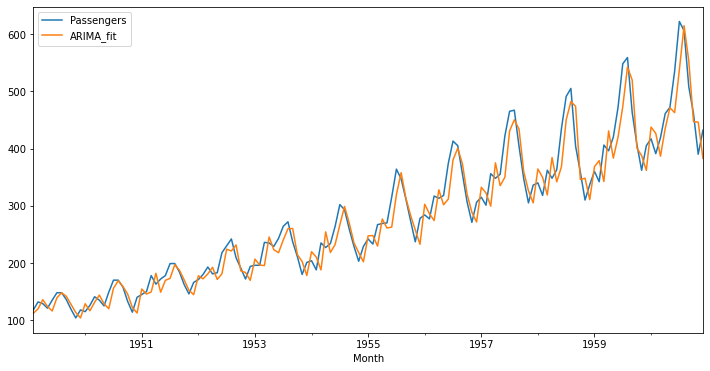

In [69]:
non_stationary_ts[1:][['Passengers','ARIMA_fit']].plot(figsize=(12,6))

<div class="alert alert-block alert-warning">
<b> 위의 그래프는, 전체 데이터에 대해서 ARIMA fit 함수가 얼마나 fit되는가를 보여준다. <br>
    실제 prediction이 잘 되는지를 확인하기 위해서는 rolling window형태로 미래 값을 예측해야 한다.
</div>

### Redisuals의 분포 점검 : 모델링의 성공 여부 평가

<AxesSubplot:ylabel='Density'>

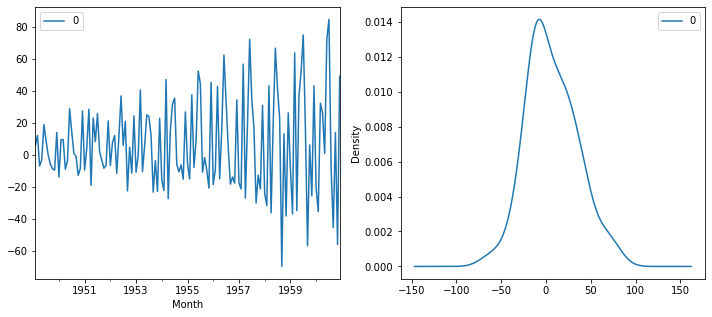

In [70]:
#plot residual errors
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
residuals = pd.DataFrame(model_fit.resid[1:])
residuals.plot(ax=ax[0])
residuals.plot(kind='kde', ax=ax[1])

# SARIMAX!
- Seasonal + ARIMA + eXogenous

<div class="alert alert-block alert-warning">
<b> 월별 주기적인 패턴을 보이는 요인 (seasonality)과 공휴일 등 외부적인 요인 (eXogenous)을 <br>
    고려할 수 있는 보다 개선된 모델은 각자 공부하자!
</div>